In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import time
import shutil
import pathlib
import itertools
import cv2
import tensorflow as tf

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121

In [3]:
import os
for dirname, _, filenames in os.walk('the-vertebrae-xray-images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N1,N,40,M_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N1,N,F,21_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N11,N,F,26_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N12,N,F,14_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N12,N,M,13_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N13,N,F,15_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N16,N,M,17_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N17,N,M,19_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N18,N,F,13_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N18,N,M,11_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N19,N,M,19_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N2,N,18,M_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N2,N,F,17_1_0.jpg
the-vertebrae-xray-images\xkt857dsxk-1\331\331\Normal\N

In [4]:
base_path = 'the-vertebrae-xray-images/xkt857dsxk-1/331/331'

In [5]:
classes = ['Normal', 'Scol', 'Spond']
image_counts = {}

for class_name in classes:
    folder_path = os.path.join(base_path, class_name)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    image_counts[class_name] = len(image_files)

df_counts = pd.DataFrame(list(image_counts.items()), columns=['Class', 'ImageCount'])

In [6]:
df_counts

,Class,ImageCount
0,Normal,71
1,Scol,185
2,Spond,78


C:\Users\HP\AppData\Local\Temp\ipykernel_8108\3624165005.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Class', y='ImageCount', palette="viridis")


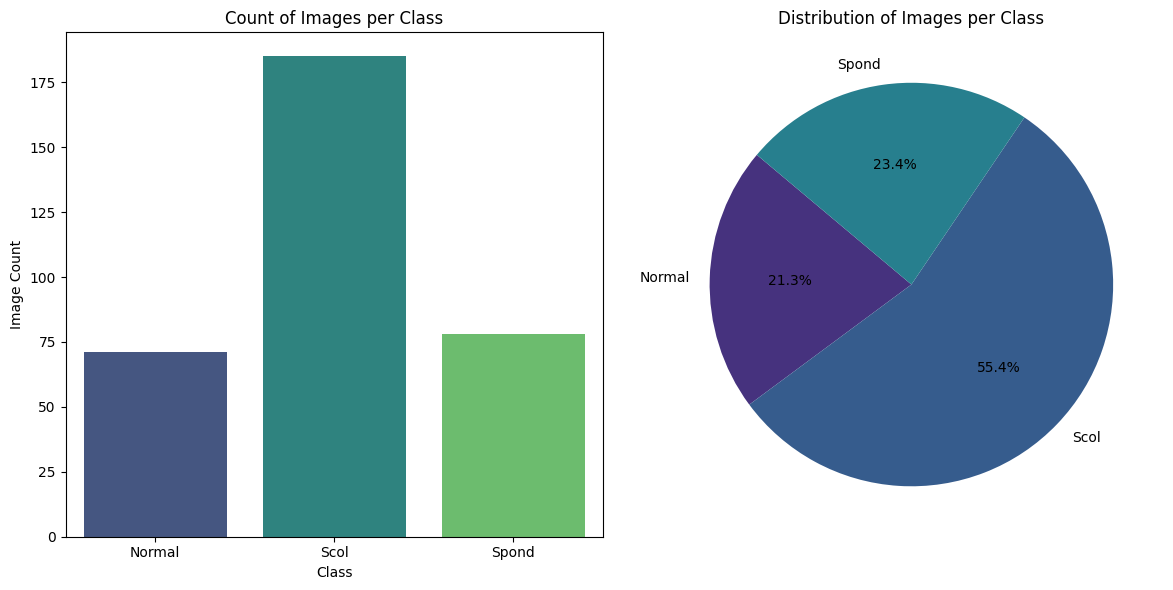

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=df_counts, x='Class', y='ImageCount', palette="viridis")
plt.title('Count of Images per Class')
plt.ylabel('Image Count')
plt.xlabel('Class')

plt.subplot(1, 2, 2)
plt.pie(df_counts['ImageCount'], labels=df_counts['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title('Distribution of Images per Class')

plt.tight_layout()
plt.show()

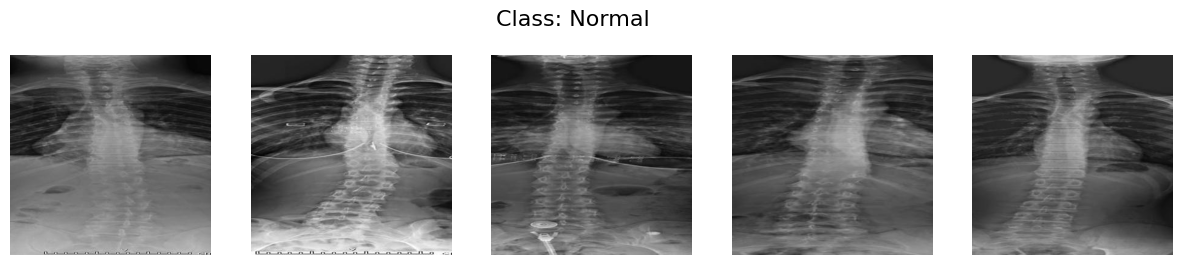

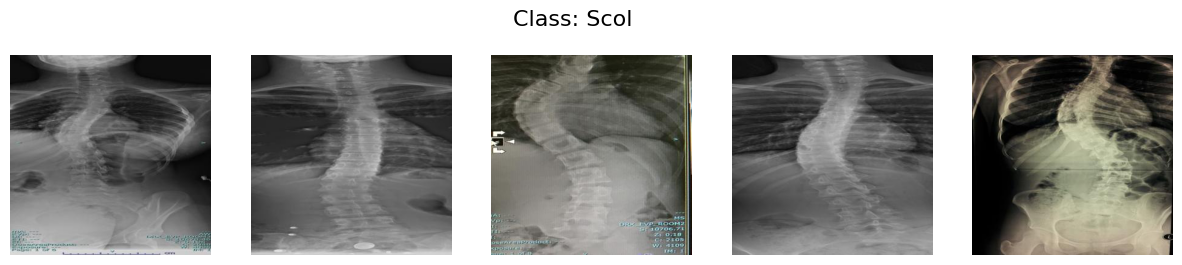

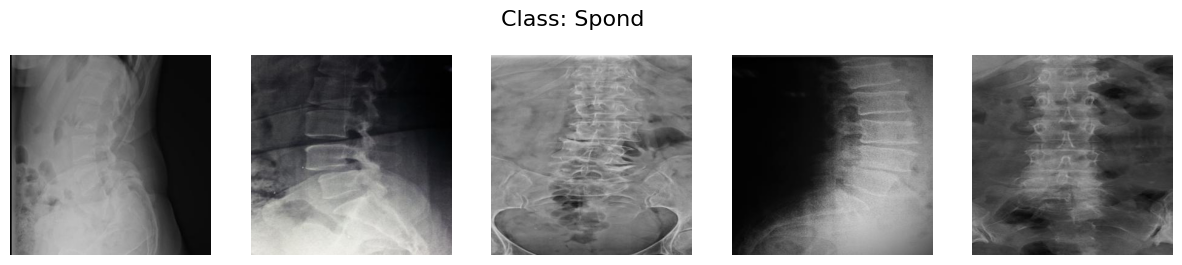

In [8]:
for class_name in classes:
    folder_path = os.path.join(base_path, class_name)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]  # Get first 5 images
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    plt.show()

In [9]:
dataset_path = base_path

In [10]:
image_data = []

folders = {'Normal': 1, 'Scol': 2, 'Spond': 3}

for folder_name, label in folders.items():
    folder_path = os.path.join(dataset_path, folder_name)
    
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        
        for image_file in image_files:
            image_data.append((os.path.join(folder_path, image_file), label))
    else:
        print(f"Folder {folder_path} not found.")

df = pd.DataFrame(image_data, columns=['image_path', 'label'])

In [11]:
df.head()

,image_path,label
0,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
1,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
2,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
3,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
4,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1


In [12]:
df.tail()

,image_path,label
333,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
334,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
335,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
336,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
337,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3


In [13]:
df.shape

(338, 2)

In [14]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [15]:
df.duplicated().sum()

0

In [16]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  338 non-null    object
 1   label       338 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [18]:
df.describe()

,label
count,338.000000
mean,2.023669
std,0.666740
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [19]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['label'])

In [20]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['label'] = y_resampled

In [21]:
print("\nClass distribution after Oversampling => ")
print(df_resampled['label'].value_counts())


Class distribution after Oversampling => 
label
1    188
2    188
3    188
Name: count, dtype: int64


In [22]:
df_resampled

,image_path,label
0,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
1,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
2,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
3,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
4,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,1
...,...,...
559,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
560,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
561,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3
562,the-vertebrae-xray-images/xkt857dsxk-1/331/331...,3


In [23]:
sns.set_style('darkgrid')

In [24]:
import warnings
warnings.filterwarnings("ignore")

print ('Check------')

Check------


In [25]:
df_resampled['label'] = df_resampled['label'].astype(str)

In [26]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['label']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['label'] 
)

In [27]:
batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='label',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 451 validated image filenames belonging to 3 classes.
Found 56 validated image filenames belonging to 3 classes.
Found 57 validated image filenames belonging to 3 classes.


In [28]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
def create_xception_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 7, 7, 2048  
    x = Reshape((height * width, channels))(x)  
   
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x) 

    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [31]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.7801 - loss: 0.6397 - val_accuracy: 0.6607 - val_loss: 0.7326
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.9389 - loss: 0.1729 - val_accuracy: 0.9286 - val_loss: 0.2329
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9646 - loss: 0.0798 - val_accuracy: 0.9643 - val_loss: 0.1590
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9370 - loss: 0.1874 - val_accuracy: 0.9643 - val_loss: 0.1320
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9817 - loss: 0.0530 - val_accuracy: 0.9464 - val_loss: 0.0987


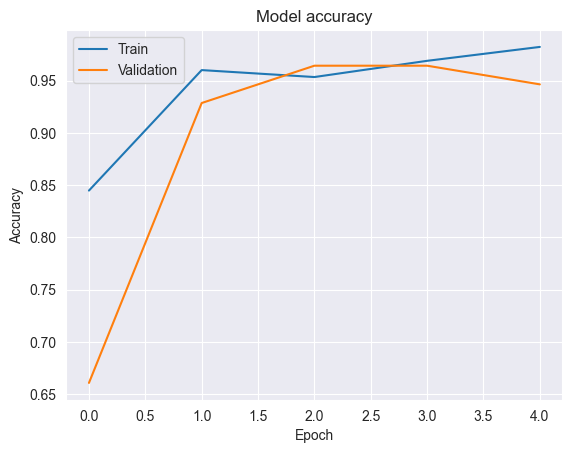

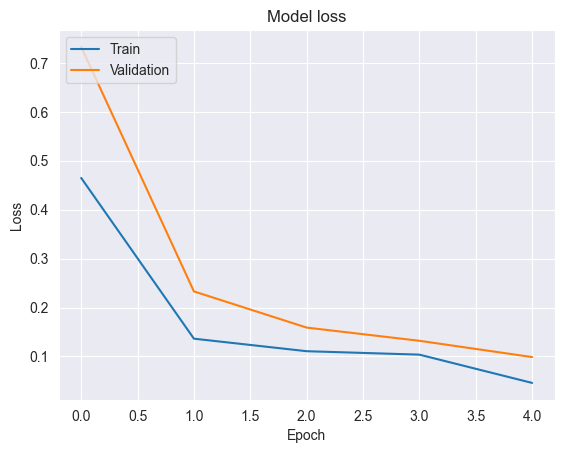

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [34]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print("Classification Report => ")
print(report)

Classification Report => 
              precision    recall  f1-score   support

           1       0.90      1.00      0.95        19
           2       1.00      0.95      0.97        19
           3       0.94      0.89      0.92        19

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57



In [35]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

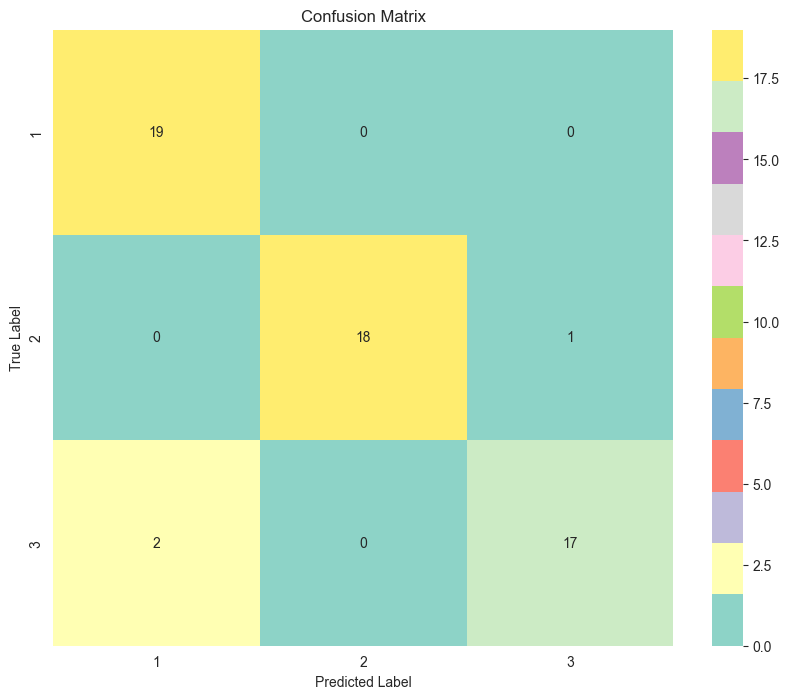

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set3', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [37]:
def create_inception_model(input_shape):
    
    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 5, 5, 2048  
    x = Reshape((height * width, channels))(x) 

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)  

    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [38]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.7862 - loss: 0.6236 - val_accuracy: 0.8214 - val_loss: 0.3798
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9343 - loss: 0.1791 - val_accuracy: 0.7500 - val_loss: 0.6926
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9632 - loss: 0.0889 - val_accuracy: 0.9107 - val_loss: 0.3984
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9951 - loss: 0.0237 - val_accuracy: 0.8036 - val_loss: 0.6368
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9979 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.5839


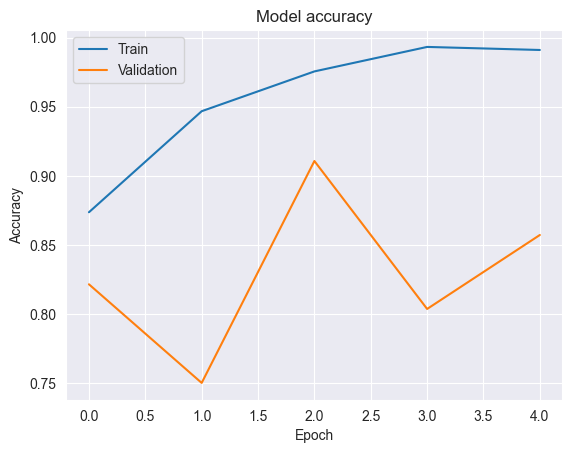

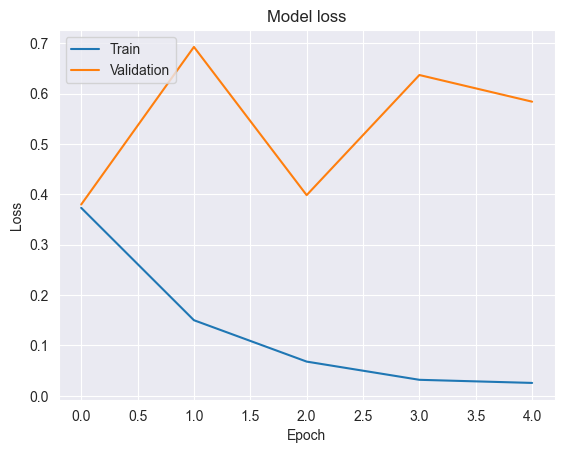

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 


In [41]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print("Classification Report => ")
print(report)

Classification Report => 
              precision    recall  f1-score   support

           1       1.00      0.84      0.91        19
           2       0.73      1.00      0.84        19
           3       1.00      0.79      0.88        19

    accuracy                           0.88        57
   macro avg       0.91      0.88      0.88        57
weighted avg       0.91      0.88      0.88        57



In [42]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

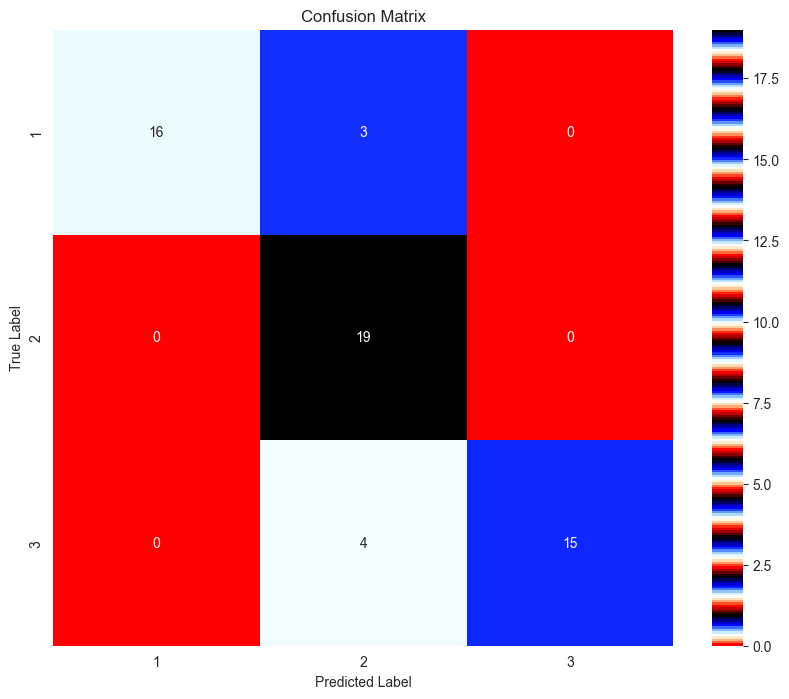

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='flag', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
def create_densenet_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    base_model = DenseNet121(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = Reshape((height * width, channels))(x)
    
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

input_shape = (224, 224, 3)
densenet_model = create_densenet_model(input_shape)

densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [45]:
history = densenet_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8283 - loss: 0.5162 - val_accuracy: 0.7679 - val_loss: 0.6044
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9656 - loss: 0.0986 - val_accuracy: 0.8929 - val_loss: 0.3634
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9742 - loss: 0.0845 - val_accuracy: 0.9643 - val_loss: 0.2706
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9802 - loss: 0.0425 - val_accuracy: 0.9821 - val_loss: 0.2055
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9811 - loss: 0.0607 - val_accuracy: 0.9821 - val_loss: 0.2665


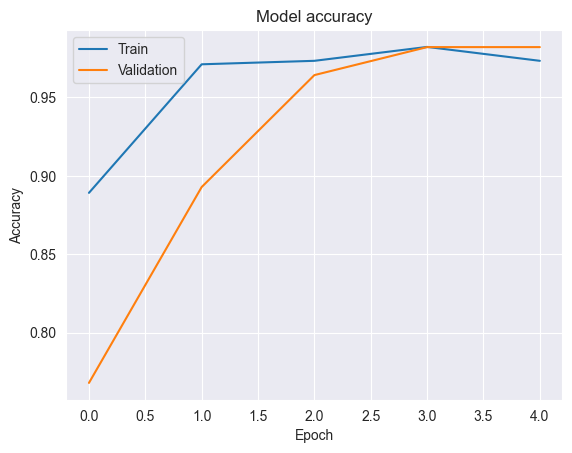

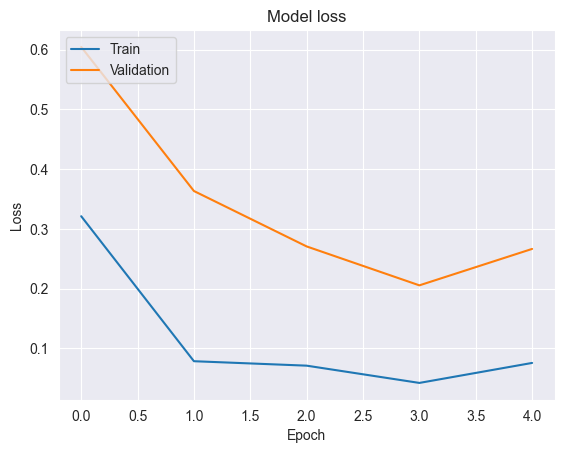

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
test_labels = test_gen_new.classes  
predictions = densenet_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A7C73ED300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 


In [48]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print("Classification Report => ")
print(report)

Classification Report => 
              precision    recall  f1-score   support

           1       1.00      0.53      0.69        19
           2       0.58      1.00      0.73        19
           3       1.00      0.74      0.85        19

    accuracy                           0.75        57
   macro avg       0.86      0.75      0.76        57
weighted avg       0.86      0.75      0.76        57



In [49]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

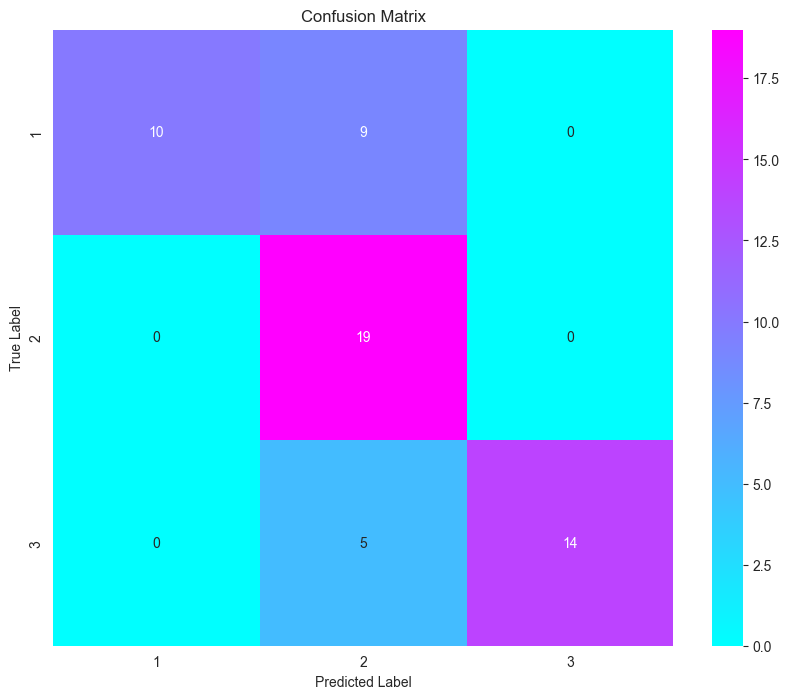

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cool', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Thanks !!!